In [1]:
import pandas as pd, numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
predict_table = pd.read_excel('./baseline_predict_test_sample500_intra+peri_20230409.xlsx')

In [4]:
def metric_calc(array_, typex_, ths):
    y_test, y_pred = array_
    report = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    sens = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn/(tn+fp)
    return [typex_, ths, acc, prec, sens, spec, f1]

In [5]:
predict_table.head(2)

,病人ID,病人透析時間,病人透析前血壓,sbp差(取最大值),mbp差(取最大值),NLP判斷結果(Y/N),BP判斷結果(Y/N),IntraHD預測分數,PeriHD預測分數,預期結果(Y/N),truth,IntraHD最高分斷句,PeriHD最高分斷句
0,09359CH38,2020-07-20 17:50:00,128/73,0,0,N,N,0.0025,0.0119,N,N,HD end || 無,透析結束後無不適，依「血液透析病人透析後防跌評估表」進行防跌篩檢：0分
1,53496939,2019-04-16 17:25:00,191/82,56,35,N,Y,0.0837,0.0333,N,N,主訴無不適情形，持續觀察至透析畢。 || 無,口頭衛教居家照服員預防跌倒注意事項，並由居家照服員協助下坐輪椅返家


In [21]:
intra_ths = 0.3
peir_ths = 0.5
mix_ths = idh_ths = 0.5
text_answer = [0 if i =='N' else 1 for i in predict_table['truth']]
intra_result = [int(i>intra_ths) for i in predict_table['IntraHD預測分數']]
peri_result = [int(i>peir_ths) for i in predict_table['PeriHD預測分數']]
mix_result = [int(i>mix_ths) if i>p else int(p>mix_ths) for i,p in zip(predict_table['IntraHD預測分數'],predict_table['PeriHD預測分數'])]
bp_result = [0 if i =='N' else 1 for i in predict_table['BP判斷結果(Y/N)']]
idh_text_answer = [1 if bp==ans and bp==1 else 0 for bp, ans in zip(bp_result, text_answer)]
idh_bp_result = [1 if bp==ans and bp==1 else 0 for bp, ans in zip(bp_result, mix_result)]

In [22]:
test_columns = ['Type', 'ths', 'Accuracy', 'Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]']

In [23]:
new_metric_table = []
for values, type_s , ths in zip([intra_result, peri_result, mix_result], ['IntraHD Test', 'PeriHD Test' ,'IP-Mix Test'], [intra_ths, peir_ths, mix_ths]):
    new_metric_table.append(metric_calc([text_answer, values], type_s, ths))
metric_calc([text_answer, values], type_s, ths)
new_metric_table.append(metric_calc([text_answer, bp_result], 'BP Judge', '-'))
new_metric_table.append(metric_calc([idh_text_answer, idh_bp_result], 'IDH Predict', idh_ths))

pd.DataFrame(new_metric_table, columns=test_columns)

,Type,ths,Accuracy,Precision [macro],Sensitivity [macro],Specificity,F1-score [macro]
0,IntraHD Test,0.3,0.871227,0.817154,0.795481,0.930412,0.805441
1,PeriHD Test,0.5,0.873239,0.896372,0.724203,0.989691,0.768842
2,IP-Mix Test,0.5,0.913481,0.869933,0.881916,0.938144,0.875702
3,BP Judge,-,0.521127,0.563729,0.591046,0.466495,0.499636
4,IDH Predict,0.5,0.951710,0.908757,0.908757,0.971360,0.908757


Text(0.5, 1.0, '[Internal]Baseline Test Data ROC-Curve')

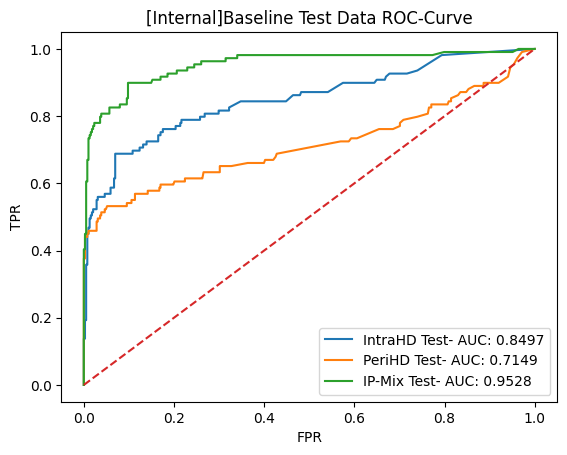

In [25]:
ax = plt.figure()
fpr, tpr, thresholds = roc_curve(text_answer, predict_table['IntraHD預測分數'], pos_label=1)
auc = roc_auc_score(text_answer, predict_table['IntraHD預測分數'])
plt.plot(fpr, tpr, label = "IntraHD Test-{} AUC: {}".format('', round(auc, 4)))

fpr, tpr, thresholds = roc_curve(text_answer, predict_table['PeriHD預測分數'], pos_label=1)
auc = roc_auc_score(text_answer, predict_table['PeriHD預測分數'])
plt.plot(fpr, tpr, label = "PeriHD Test-{} AUC: {}".format('', round(auc, 4)))

mix_predict = [i if i>p else p for i,p in zip(predict_table['IntraHD預測分數'],predict_table['PeriHD預測分數'])]
fpr, tpr, thresholds = roc_curve(text_answer, mix_predict, pos_label=1)
auc = roc_auc_score(text_answer, mix_predict)
plt.plot(fpr, tpr, label = "IP-Mix Test-{} AUC: {}".format('', round(auc, 4)))

plt.plot([0,1],[0,1], linestyle='--')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"[Internal]Baseline Test Data ROC-Curve")